In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from lambeq import BobcatParser
from lambeq import AtomicType, IQPAnsatz, remove_cups, SpiderAnsatz
from lambeq import TketModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from discopy import grammar
from discopy import Dim

from pytket.extensions.qiskit import AerBackend
from pytket.circuit.display import render_circuit_jupyter

from jax import jit, grad

from sympy import default_sort_key


2022-08-23 14:00:45.311305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 14:00:47.670256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-23 14:00:47.670277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-23 14:01:04.488868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-23 14:01:04.493597: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-23 14:01:04.493618: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maria-pc): /proc/driver/nvidia/version does not exist


In [3]:
BATCH_SIZE = 50
EPOCHS = 10
SEED = 2

In [4]:
#Input data MC1

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #sentences are split by , in our data set
            end_sentence = line.split(",")
            t = int(end_sentence[2])
            labels.append([t, 1-t])
            #there are two sentences per associated label
            #we need to make sure they are both used
            sentences.append(end_sentence[0])
            sentences.append(end_sentence[1])
    return labels, sentences

In [5]:
#Testing
print(read_data('MC1.TXT'))

([[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0]], ['cook creates complicated dish', ' experienced chef prepares complicated dish', 'skilful programmer creates code', ' devoted hacker writes code', 'skilful cook creates meal', ' devoted hacker crea

In [7]:
#we will use 15% of the data as a training set
labels, data = read_data('MC1.TXT')
train_labels, train_data = labels[0:15] , data[0:15]
test_labels, test_data = labels[15:100] , data[15:100]

In [8]:
#Parser
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [9]:

train_diagrams = [
    diagram.normal_form()
    for diagram in train_diagrams if diagram is not None]
test_diagrams = [
    diagram.normal_form()
    for diagram in test_diagrams if diagram is not None]

train_labels = [
    label for (diagram, label)
    in zip(train_diagrams, train_labels)
    if diagram is not None]
test_labels = [
    label for (diagram, label)
    in zip(test_diagrams, test_labels)
    if diagram is not None]


In [10]:
#Circuits

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]


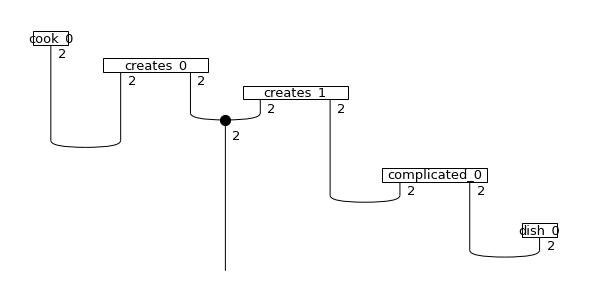

In [11]:
# Create ansatz and convert to tensor diagrams

N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz by assigning 2 dimensions to both
# noun and sentence spaces
ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(d) for d in train_diagrams]
test_circuits = [ansatz(d) for d in test_diagrams]

all_circuits = train_circuits + test_circuits

all_circuits[0].draw(figsize=(8,4), fontsize=13)

In [177]:
#Model

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

class MyCustomModel(input_training,input_testing,train_circuits,test_circuits):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)
    
    def training(self,input_training)
        training_tags = []
        food_keywords = ['chef','dish','meal','tasty','prepares']
        code_keywords = ['programmer','code','hacker','writes']

        for i in range(np.size(input_training)):
            words = [word for word in input_training[i].split()]
            for l in words:
                for j in food_keywords:
                    if l == j:
                        training_tags.append(0)
                for k in code_keywords:
                    if l == k:
                        training_tags.append(1)
        return training_tags
    #I expect them to be: training_tags = [0,0,1,1,0,1,1,1,1,1,1,1,0,0,1]

    def forward(self, input):
        
        #model results associated with circuit formats
        food_circuits = []
        code_circuits = []
        forward_circuit = []


        #model associated with data similarities     
        food_data = []
        code_data = []
        forward_data = []


        
        return forward_circuit,forward_data

custom_model = MyCustomModel


'\nall_circuits = train_circuits + test_circuits\n\nbackend = AerBackend()\nbackend_config = {\n    \'backend\': backend,\n    \'compilation\': backend.default_compilation_pass(2),\n    \'shots\': 8192\n}\n\n\'\'\'\n#Standart model\nmodel = TketModel.from_diagrams(all_circuits, backend_config=backend_config)\n\'\'\'\n\nclass MyCustomModel():\n    def __init__(self):\n        super().__init__()\n        self.net = torch.nn.Linear(2, 2)\n\n    def forward(self, input):\n        food_circuits = []\n        code_circuits = []\n        food_data = []\n        code_data = []\n        #training data\n        training_tags = [0,0,1,1,0,1,1,1,1,1,1,1,0,0,1]\n        for i in range(np.size(input_training)):\n            if training_tags[i] == 0:\n                food_circuits.append(train_circuits[i])\n                food_data.append(input_training[i])\n            elif training_tags[i] == 1:\n                code_circuits.append(train_circuits[i])\n                code_data.append(input_traini

In [178]:
# Create vocabulary
all_circuits = train_circuits + test_circuits

vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
tensors = [np.random.rand(w.size) for w in vocab]

tensors[0]

array([0.94382759, 0.68678337, 0.28757538, 0.76899892])

In [179]:
#Loss & eval metrics
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(tensors):
    # Lambdify
    np_circuits = [c.lambdify(*vocab)(*tensors) for c in train_circuits]
    # Compute predictions
    predictions =  sigmoid(np.array([c.eval().array for c in np_circuits]))

    # binary cross-entropy loss
    cost = -np.sum(train_labels * np.log2(predictions)) / len(train_labels)
    return cost


training_loss = jit(loss)
gradient = jit(grad(loss))


In [180]:
#Trainer
training_losses = []

for i in range(EPOCHS):
    gr = gradient(tensors)
    for k in range(len(tensors)):
        tensors[k] = tensors[k] - gr[k] * 1.0

    training_losses.append(float(training_loss(tensors)))

    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1} - loss {training_losses[-1]}")



TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[2])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[2])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[2]), None)
    recipe = LambdaBinding()
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
#Create dataset
"""
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

test_dataset = Dataset(test_circuits, test_labels, shuffle=False)
"""

In [ ]:
#Train model
"""
trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=100)
"""

Epoch 1:    train/loss: 4.1082   valid/loss: 3.8586   train/acc: 0.3000   valid/acc: 0.5176
Epoch 100:  train/loss: 0.4479   valid/loss: 1.5248   train/acc: 0.8667   valid/acc: 0.5235

Training completed!


In [ ]:
# Testing

np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
test_predictions =  sigmoid(np.array([c.eval().array for c in np_test_circuits]))

hits = 0
for i in range(len(np_test_circuits)):
    target = test_targets[i]
    pred = test_predictions[i]
    if np.argmax(target) == np.argmax(pred):
        hits += 1

print("Accuracy on test set:", hits / len(np_test_circuits))

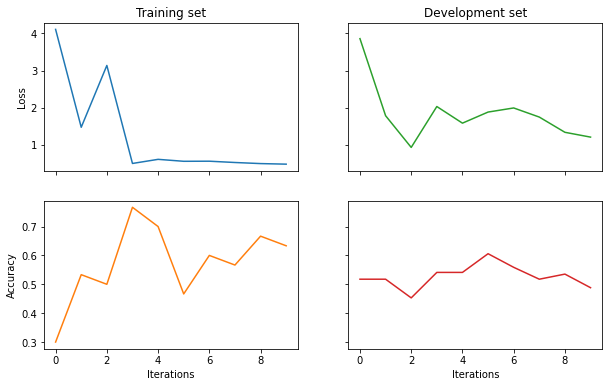

In [ ]:
#Printing train model
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))